In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from statsmodels.formula.api import ols
import pandas as pd
from cds import plotting
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.api import anova_lm

tc = TaigaClient()

In [2]:
#OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
rnaseq_strandness_inference = tc.get(name='rnaseq-strandness-inference-cae2', version=1, file='rnaseq_strandness_inference')
tc = create_taiga_client_v3()
df_gene_effect = tc.get('internal-23q4-ac2b.68/CRISPRGeneEffect')

In [3]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]
rnaseq_strandness_inference['model_id'] = rnaseq_strandness_inference.Profile.map(profile_to_model_dict)
gene_eff_with_strand = rnaseq_strandness_inference.loc[:, ['strandness', 'model_id']].merge(df_gene_effect, left_on='model_id', right_index=True).fillna(0)
gene_eff_with_strand.columns = gene_eff_with_strand.columns.map(lambda x: x.split()[0])
gene_eff_with_strand.columns = gene_eff_with_strand.columns.map(lambda x: x.replace("-", "_"))

In [5]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

4664 3079 3079 6499.1648923755665


Text(0.5, 0, 'CRISPR gene effect ANOVA Bonjemini-Hochberg FDR value with strandness')

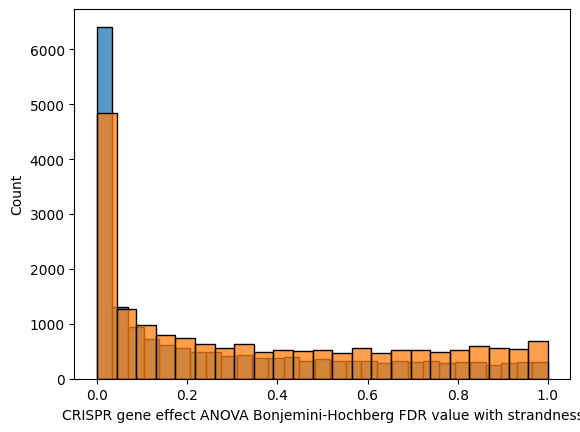

In [6]:
PR_dict = {}
t_stat = {}
coef_stat = {}
eta_sq = {}
omega_sq = {}
effect_size = {}
for gene in gene_eff_with_strand.columns[2:]:
    gene_exp_with_strand_lm = ols(f"{gene} ~ C(strandness)", data=gene_eff_with_strand).fit()
    effect_size[gene] = np.mean(gene_eff_with_strand[gene][gene_eff_with_strand.strandness])-np.mean(gene_eff_with_strand[gene][~gene_eff_with_strand.strandness])
    table9 = anova_lm(gene_exp_with_strand_lm, type=2)
    table9 = anova_table(table9)
    t_stat[gene] = float(pd.DataFrame(gene_exp_with_strand_lm.summary().tables[1].data).iloc[2, 3].strip())
    eta_sq[gene] = table9.loc[:, 'eta_sq'][0]
    omega_sq[gene] = table9.loc[:, 'omega_sq'][0]
    coef_stat[gene] = gene_exp_with_strand_lm.params[1]
    PR_dict[gene] = table9.loc[:, 'PR(>F)'][0]

PR_series = pd.Series(PR_dict)
t_series = pd.Series(t_stat)
coef_stat = pd.Series(coef_stat)
omega_sq_series = pd.Series(omega_sq)
eta_sq_series = pd.Series(eta_sq)
effect_size = pd.Series(effect_size)


from statsmodels.stats.multitest import multipletests
tests_bh = multipletests(PR_series, alpha=0.01, method="fdr_bh")
print((PR_series<0.01).sum(), tests_bh[0].sum(), (tests_bh[1]<0.01).sum(), tests_bh[1].sum())

sns.histplot(PR_series)
plt.xlabel("CRISPR gene effect ANOVA nominial p value with strandness")
sns.histplot(tests_bh[1])
plt.xlabel("CRISPR gene effect ANOVA Bonjemini-Hochberg FDR value with strandness")


<Axes: xlabel='t_statistics', ylabel='FDR'>

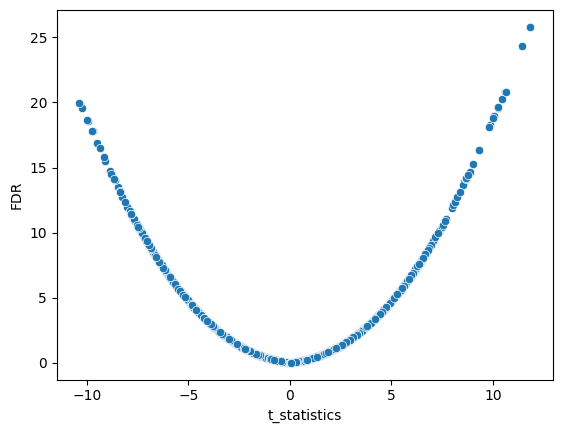

In [7]:
fig, ax = plt.subplots()
crispr_confounding_test = pd.DataFrame({"gene": t_series.index, 
                                        "omega_sq": omega_sq_series,
                                        "eta_sq": eta_sq_series,
                                        "effect_size": effect_size,
                                        "t_statistics": t_series,
                                        "coef": coef_stat,
                                        "FDR": -np.log10(tests_bh[1])})
sns.scatterplot(x="t_statistics", y="FDR", data=crispr_confounding_test)

In [8]:
crispr_confounding_test.head()

,gene,omega_sq,eta_sq,effect_size,t_statistics,coef,FDR
A1BG,A1BG,-0.000822,0.000031,0.001164,0.192,0.001164,0.040846
A1CF,A1CF,0.002236,0.003090,-0.012632,-1.904,-0.012632,0.842128
A2M,A2M,0.004645,0.005499,0.014809,2.544,0.014809,1.371358
A2ML1,A2ML1,0.000480,0.001334,0.007218,1.250,0.007218,0.435516
A3GALT2,A3GALT2,0.005095,0.005949,-0.020052,-2.646,-0.020052,1.466797


In [9]:
crispr_confounding_test = pd.DataFrame({"gene": t_series.index, 
                                        "omega_sq": omega_sq_series,
                                        "eta_sq": eta_sq_series,
                                        "effect_size": effect_size,
                                        "t_statistics": t_series,
                                        "coef": coef_stat,
                                        "FDR": tests_bh[1]})
crispr_confounding_test.loc[['TP53', 'MYC', 'KRAS', 'MTAP']]

,gene,omega_sq,eta_sq,effect_size,t_statistics,coef,FDR
TP53,TP53,0.012948,0.013802,0.120875,4.046,0.120875,0.000670
MYC,MYC,0.007878,0.008731,0.129083,3.210,0.129083,0.008547
KRAS,KRAS,0.003507,0.004361,0.080137,2.264,0.080137,0.075049
MTAP,MTAP,0.000295,0.001149,0.009345,1.160,0.009345,0.407925


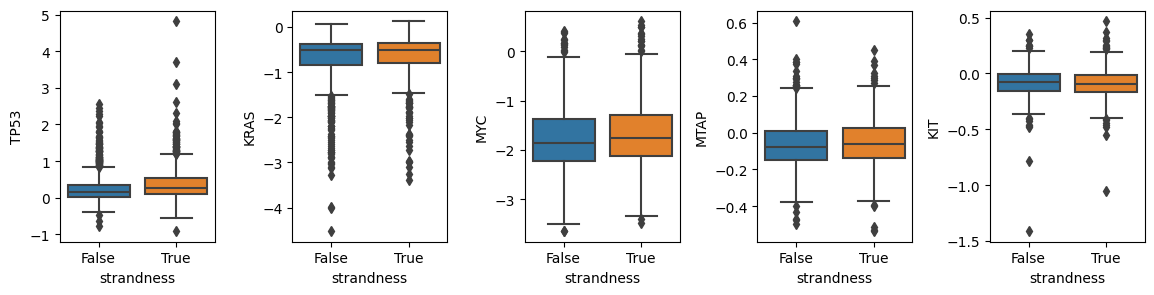

In [25]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(14, 3)
sns.boxplot(x='strandness', y='TP53', data=gene_eff_with_strand, ax=ax[0])
sns.boxplot(x='strandness', y='KRAS', data=gene_eff_with_strand, ax=ax[1])
sns.boxplot(x='strandness', y='MYC', data=gene_eff_with_strand, ax=ax[2])
sns.boxplot(x='strandness', y='MTAP', data=gene_eff_with_strand, ax=ax[3])
sns.boxplot(x='strandness', y='KIT', data=gene_eff_with_strand, ax=ax[4])
fig.subplots_adjust(wspace=0.5)

# Overlap with the oncoKB genes

In [9]:
oncokb = pd.read_csv("~/OncoKB_Annotated_Final_2024-03-19_08-12-54.csv")

In [10]:
oncokb.head()

,Chromosome,Position,Ref,Alt,EntrezGeneID,HugoSymbol,ProteinChange,HgvsFormat,Oncogenic,MutationEffect,Citation_PMIDs,HighestSensitiveLevel,HighestResistanceLevel,Hotspot
0,chr1,26732685,C,T,8289.0,ARID1A,Q605*,1:g.26732685C>T,Likely Oncogenic,Likely Loss-of-function,"['21900401', '24899687', '22009941', '25625625']",LEVEL_4,NaN,False
1,chr1,235229231,T,C,NaN,ARID4B,E299E,1:g.235229231T>C,Likely Oncogenic,Likely Loss-of-function,"['24382590', '18728284']",NaN,NaN,False
2,chr2,47783349,G,A,2956.0,MSH6,G39E,2:g.47783349G>A,Inconclusive,Inconclusive,['24362816'],NaN,NaN,False
3,chr2,141059052,A,G,NaN,LRP1B,V413V,2:g.141059052A>G,Likely Oncogenic,Likely Loss-of-function,"['28408316', '33653800']",NaN,NaN,False
4,chr3,37048980,A,G,4292.0,MLH1,Q448R,3:g.37048980A>G,Inconclusive,Inconclusive,"['25092538', '24362816']",NaN,NaN,False


In [11]:
crispr_confounding_test['oncokb'] = crispr_confounding_test.index.isin(oncokb.HugoSymbol)

In [12]:
crispr_confounding_test.oncokb.sum()

428

In [13]:
pd.crosstab(crispr_confounding_test.FDR < 0.05, crispr_confounding_test.oncokb)

oncokb,False,True
FDR,,
False,13075,322
True,4940,106


In [14]:
crispr_confounding_test.head()

,gene,omega_sq,eta_sq,effect_size,t_statistics,coef,FDR,oncokb
A1BG,A1BG,-0.000822,0.000031,0.001164,0.192,0.001164,0.910237,False
A1CF,A1CF,0.002236,0.003090,-0.012632,-1.904,-0.012632,0.143838,False
A2M,A2M,0.004645,0.005499,0.014809,2.544,0.014809,0.042525,False
A2ML1,A2ML1,0.000480,0.001334,0.007218,1.250,0.007218,0.366846,False
A3GALT2,A3GALT2,0.005095,0.005949,-0.020052,-2.646,-0.020052,0.034135,False


In [15]:
crispr_confounding_test = crispr_confounding_test.sort_values("FDR")

In [18]:
tc = TaigaClient()
crispr_confounding_test.to_csv("crispr_confounding_test.csv")
new_dataset_id = tc.create_dataset(
    "rnaseq_strandness_association_with_crispr",
    dataset_description="strandness confouding association for CRISPR gene effect scores",
    upload_files=[
        {
            "path": "crispr_confounding_test.csv",
            "name": "rnaseq_strandness_association_with_crispr", # optional, will use file name if not provided
            "format": "TableCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    #folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
)

# Drug compound table evaluation

In [ ]:
# Repurposing_23Q2_Extended_Primary_Data_Matrix = tc.get(name='repurposing-23q2-a803', version=2, file='Repurposing_23Q2_Extended_Primary_Data_Matrix')
# Repurposing_23Q2_Extended_Primary_Compound_List = tc.get(name='repurposing-23q2-a803', version=2, file='Repurposing_23Q2_Extended_Primary_Compound_List')
# Repurposing_23Q2_QC_table = tc.get(name='repurposing-23q2-a803', version=2, file='Repurposing_23Q2_QC_table')

[                      ]  0% |   0.0 s/B |   0.0 B /  31.2 MiB | ETA:  --:--:--
[##                ] 16% |  89.9 MiB/s |   5.0 MiB /  31.2 MiB | ETA:   0:00:00
[########          ] 48% | 135.8 MiB/s |  15.0 MiB /  31.2 MiB | ETA:   0:00:00
[#########         ] 54% |  75.6 MiB/s |  17.0 MiB /  31.2 MiB | ETA:   0:00:00
[##############    ] 83% |  94.1 MiB/s |  26.0 MiB /  31.2 MiB | ETA:   0:00:00
[##################]100% |  24.6 MiB/s |  31.2 MiB /  31.2 MiB | Time:  0:00:01
[                      ]  0% |   0.0 s/B |   0.0 B / 162.8 KiB | ETA:  --:--:--
[##################]100% | 199.7 MiB/s | 162.8 KiB / 162.8 KiB | ETA:  00:00:00
[                      ]  0% |   0.0 s/B |   0.0 B / 868.3 KiB | ETA:  --:--:--
[#################]100% | 1009.4 MiB/s | 868.3 KiB / 868.3 KiB | ETA:  00:00:00


In [27]:
PRISMOncologyReferenceAUCMatrix = tc.get(name='prism-oncology-reference-set-23q4-1a7c', version=17, file='PRISMOncologyReferenceAUCMatrix')


[                      ]  0% |   0.0 s/B |   0.0 B /   1.4 MiB | ETA:  --:--:--
[##################]100% |  50.0 MiB/s |   1.4 MiB /   1.4 MiB | Time:  0:00:00


In [28]:
PRISMOncologyReferenceAUCMatrix.head()

,ACH-000001,ACH-000002,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000010,ACH-000011,ACH-000012,...,ACH-002016,ACH-002022,ACH-002023,ACH-002025,ACH-002038,ACH-002039,ACH-002041,ACH-002042,ACH-002046,ACH-002048
BRD-A12230535-001-10-9,0.932531,NaN,0.911922,0.957858,0.989272,0.780529,0.765711,0.939085,0.859220,0.844487,...,0.819954,0.841515,0.823430,0.996145,0.910479,0.903084,0.914203,0.941779,0.902386,0.609194
BRD-K05804044-001-19-3,NaN,NaN,0.794258,0.842019,0.916031,0.476391,0.517499,0.737071,0.930624,0.903640,...,0.823395,0.584874,0.832443,0.698933,1.000000,0.602104,0.939113,0.431174,0.718503,0.754111
PRC-000015573-601-10,NaN,NaN,0.986345,0.748302,0.580672,0.856249,0.844799,0.742704,0.807275,0.899043,...,0.983082,0.609311,0.837216,0.869808,0.784826,0.905372,0.878717,0.657337,0.885789,0.852476
PRC-000110991-778-86,0.963946,0.80526,0.908659,0.886750,0.986520,0.975168,NaN,0.465092,0.812880,0.902269,...,0.779386,0.891848,0.954639,0.992182,0.898529,0.945770,0.969085,NaN,0.917683,0.768533
PRC-000133824-529-61,NaN,NaN,0.915187,0.806775,0.705946,0.704357,NaN,0.979987,NaN,0.997014,...,NaN,0.853152,0.933534,0.913601,NaN,0.736160,0.968112,0.865477,0.808330,0.731053


In [29]:
oncref_with_strand = rnaseq_strandness_inference.loc[:, ['strandness', 'model_id']].merge(PRISMOncologyReferenceAUCMatrix.T, left_on='model_id', right_index=True).fillna(0)

In [30]:
oncref_with_strand.head()

,strandness,model_id,BRD-A12230535-001-10-9,BRD-K05804044-001-19-3,PRC-000015573-601-10,PRC-000110991-778-86,PRC-000133824-529-61,PRC-000135156-525-58,PRC-000149574-306-49,PRC-000163629-334-62,...,PRC-009589825-724-74,PRC-009596036-672-48,PRC-009632232-593-07,PRC-009681851-003-11,PRC-009711803-373-96,PRC-009759078-843-28,PRC-009800936-471-41,PRC-009903739-787-97,PRC-009953236-412-07,PRC-009978965-422-11
0,True,ACH-001113,0.992837,0.733920,0.772164,0.000000,0.880195,0.798024,1.000000,0.498834,...,0.710403,0.624493,0.975867,0.858991,0.628661,0.971771,0.569320,0.937626,0.859838,0.849817
1,True,ACH-001289,0.779245,0.950564,0.000000,0.771792,0.000000,0.780607,1.000000,0.673020,...,0.919504,0.795063,0.000000,0.720026,0.862010,0.000000,0.610286,0.000000,0.826507,0.000000
7,False,ACH-000167,0.671457,0.907853,0.792776,0.926673,0.000000,0.944095,0.904755,0.441917,...,0.699549,0.838082,0.978332,0.898356,0.535306,0.983447,0.562505,0.920479,0.823037,0.000000
8,False,ACH-000792,0.940726,0.939958,0.926903,0.834380,0.000000,0.892178,0.985699,0.647665,...,0.586223,0.852317,0.898100,0.671226,0.668928,0.987956,0.547284,0.967007,0.867796,0.998342
10,True,ACH-001538,0.898139,0.702687,0.955461,0.965659,0.773638,0.917547,0.000000,0.513190,...,0.932213,0.671822,0.000000,0.826517,0.677689,0.997119,0.639145,0.990141,0.970023,0.999083


In [33]:
oncref_with_strand.columns = oncref_with_strand.columns.str.replace("-", "_")

In [35]:
oncref_with_strand.head()

,strandness,model_id,BRD_A12230535_001_10_9,BRD_K05804044_001_19_3,PRC_000015573_601_10,PRC_000110991_778_86,PRC_000133824_529_61,PRC_000135156_525_58,PRC_000149574_306_49,PRC_000163629_334_62,...,PRC_009589825_724_74,PRC_009596036_672_48,PRC_009632232_593_07,PRC_009681851_003_11,PRC_009711803_373_96,PRC_009759078_843_28,PRC_009800936_471_41,PRC_009903739_787_97,PRC_009953236_412_07,PRC_009978965_422_11
0,True,ACH-001113,0.992837,0.733920,0.772164,0.000000,0.880195,0.798024,1.000000,0.498834,...,0.710403,0.624493,0.975867,0.858991,0.628661,0.971771,0.569320,0.937626,0.859838,0.849817
1,True,ACH-001289,0.779245,0.950564,0.000000,0.771792,0.000000,0.780607,1.000000,0.673020,...,0.919504,0.795063,0.000000,0.720026,0.862010,0.000000,0.610286,0.000000,0.826507,0.000000
7,False,ACH-000167,0.671457,0.907853,0.792776,0.926673,0.000000,0.944095,0.904755,0.441917,...,0.699549,0.838082,0.978332,0.898356,0.535306,0.983447,0.562505,0.920479,0.823037,0.000000
8,False,ACH-000792,0.940726,0.939958,0.926903,0.834380,0.000000,0.892178,0.985699,0.647665,...,0.586223,0.852317,0.898100,0.671226,0.668928,0.987956,0.547284,0.967007,0.867796,0.998342
10,True,ACH-001538,0.898139,0.702687,0.955461,0.965659,0.773638,0.917547,0.000000,0.513190,...,0.932213,0.671822,0.000000,0.826517,0.677689,0.997119,0.639145,0.990141,0.970023,0.999083


In [37]:
oncref_with_strand.shape

(865, 205)

19 0 0 117.45740273682111


Text(0.5, 0, 'oncref ANOVA Bonjemini-Hochberg FDR value with strandness')

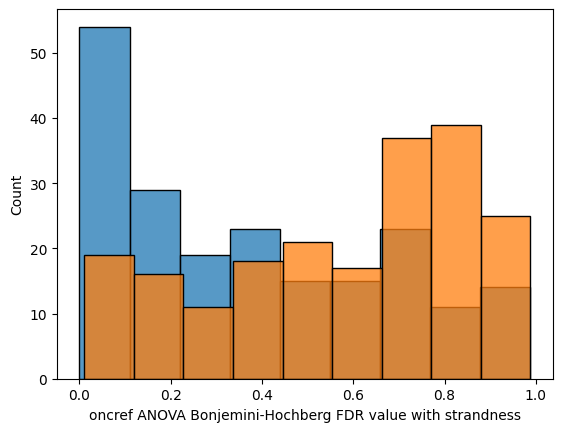

In [36]:
PR_dict = {}
t_stat = {}
coef_stat = {}
eta_sq = {}
omega_sq = {}
effect_size = {}
for gene in oncref_with_strand.columns[2:]:
    gene_exp_with_strand_lm = ols(f"{gene} ~ C(strandness)", data=oncref_with_strand).fit()
    effect_size[gene] = np.mean(oncref_with_strand[gene][oncref_with_strand.strandness])-np.mean(oncref_with_strand[gene][~oncref_with_strand.strandness])
    table9 = anova_lm(gene_exp_with_strand_lm, type=2)
    table9 = anova_table(table9)
    t_stat[gene] = float(pd.DataFrame(gene_exp_with_strand_lm.summary().tables[1].data).iloc[2, 3].strip())
    eta_sq[gene] = table9.loc[:, 'eta_sq'][0]
    omega_sq[gene] = table9.loc[:, 'omega_sq'][0]
    coef_stat[gene] = gene_exp_with_strand_lm.params[1]
    PR_dict[gene] = table9.loc[:, 'PR(>F)'][0]

PR_series = pd.Series(PR_dict)
t_series = pd.Series(t_stat)
coef_stat = pd.Series(coef_stat)
omega_sq_series = pd.Series(omega_sq)
eta_sq_series = pd.Series(eta_sq)
effect_size = pd.Series(effect_size)

from statsmodels.stats.multitest import multipletests
tests_bh = multipletests(PR_series, alpha=0.01, method="fdr_bh")
print((PR_series<0.01).sum(), tests_bh[0].sum(), (tests_bh[1]<0.01).sum(), tests_bh[1].sum())

sns.histplot(PR_series)
plt.xlabel("oncref ANOVA nominial p value with strandness")
sns.histplot(tests_bh[1])
plt.xlabel("oncref ANOVA Bonjemini-Hochberg FDR value with strandness")


In [40]:
oncref_confounding_test = pd.DataFrame({"drug": t_series.index.str.replace("_", "-"), 
                                        "omega_sq": omega_sq_series,
                                        "eta_sq": eta_sq_series,
                                        "effect_size": effect_size,
                                        "t_statistics": t_series,
                                        "coef": coef_stat,
                                        "FDR": tests_bh[1]})

In [42]:
(oncref_confounding_test.FDR<0.01).sum()

0

In [46]:
oncref_confounding_test.to_csv("oncoref_confounding_test.csv")
tc = TaigaClient()
new_dataset_id = tc.create_dataset(
    "oncoref_confounding_test",
    #dataset_description="strandness confouding association for OncRef AUC scores",
    upload_files=[
        {
            "path": "oncoref_confounding_test.csv",
            "name": "oncoref_confounding_test", # optional, will use file name if not provided
            "format": "TableCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    #folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
)

/home/ubuntu/taigapy/taigapy/client.py:497: UserWarning: upload_async == True but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.
  warnings.warn(f"upload_async == {upload_async} but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.")


Finished uploading oncoref_confounding_test to S3
Uploading oncoref_confounding_test to Taiga
Finished uploading oncoref_confounding_test to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/32d2b4ccb7584049a13bf29aef86b11d

